# Synapse Tracking

In this notebook, we demonstrate the usage of the module trackpy to track synapses in two-photon microscopy images.

First, we need to set up imports.

In [1]:
import sys
sys.path.append('../zdavidli/tracking/')
import utils
import plotting

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns

mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import trackpy as tp
from skimage import measure, io
import imageio

Here, we load in the images with which we'll be doing detection and tracking.

In [4]:
base_image_paths = ['./data/annotated_substack/R04_tp1_substack (17-32).tif', 
                    './data/annotated_substack/R04_tp2_substack (17-32).tif',
                    './data/annotated_substack/R04_tp3_substack (19-34).tif',
                    './data/annotated_substack/R04_tp4_substack (20-35).tif'
                   ]

plos_result_paths = ['./data/annotated_substack/R04_tp1_substack_results.tif',
                     './data/annotated_substack/R04_tp2_substack_results.tif',
                     './data/annotated_substack/R04_tp3_substack_results.tif',
                     './data/annotated_substack/R04_tp4_substack_results.tif'
                    ]

In [5]:
base_images = [io.imread(path) for path in base_image_paths]
plos_images = [io.imread(path) for path in plos_result_paths]

# Looking at the data

Let's look at what images we're dealing with. Shown here is the second z-slice (because it's annotated) in the first timepoint.

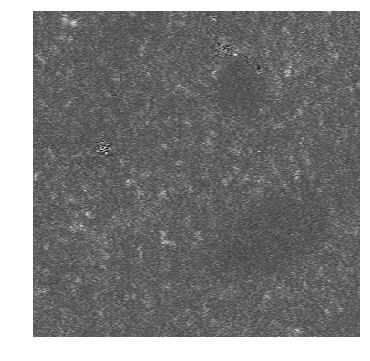

In [6]:
plt.imshow(base_images[0][1])
plt.axis('off');

In [7]:
#empirical clipping to remove large values. Should be automated in the future
base_images = [image.clip(-2500, 10000) for image in base_images]

By processing outlier points, we make the image look more like the image seen in FIJI. We're unsure what exactly FIJI does in terms of processing but this is a close approximation.

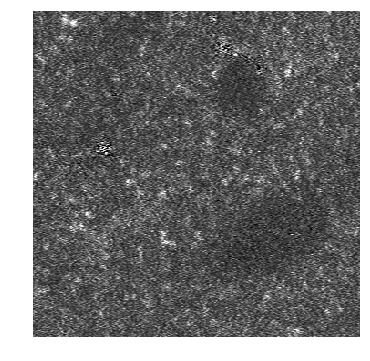

In [8]:
plt.imshow(base_images[0][1])
plt.axis('off');

Let's also look at the PLoS result probability map. The one used here is the 0.9 threshold probability map for synapses.

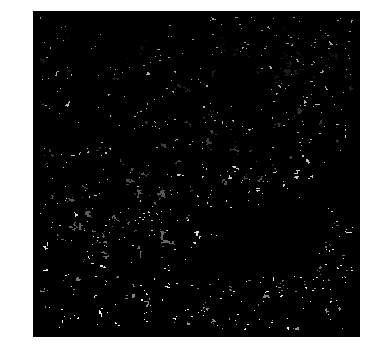

In [9]:
plt.imshow(plos_images[0][1])
plt.axis('off');

What about the rest of the annotations?

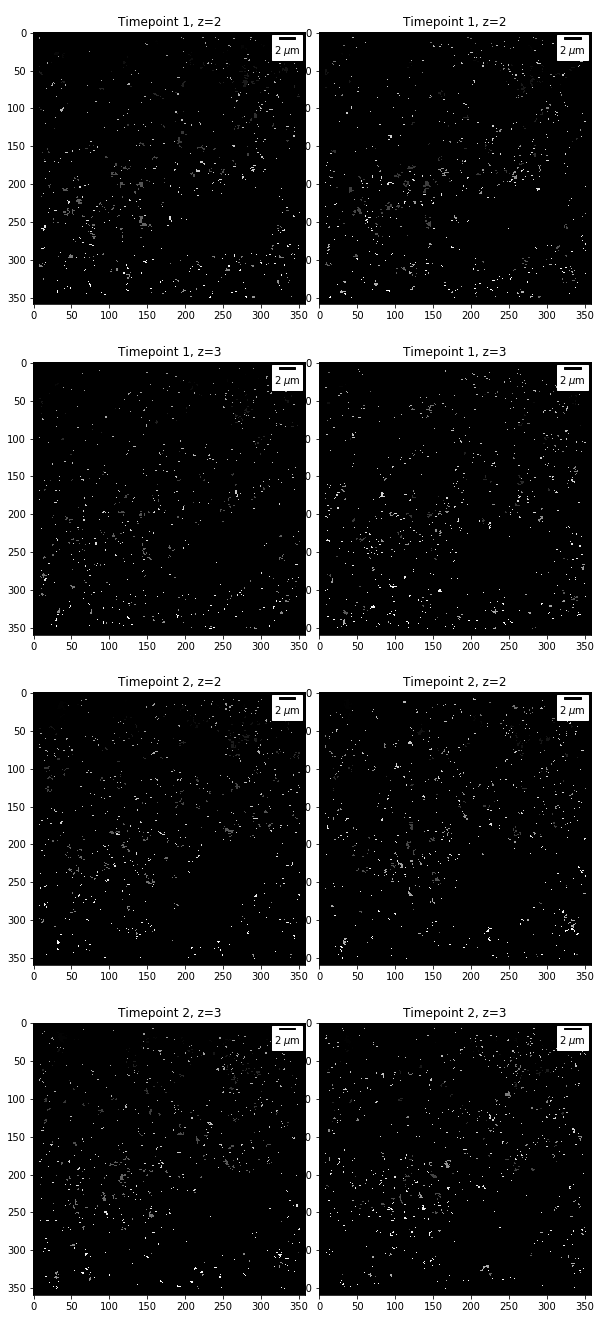

In [10]:
plt.figure(figsize=(10, 24))
plt.axis('off')

fig = plt.gcf()
gs1 = mpl.gridspec.GridSpec(4, 2)
gs1.update(wspace=0.05, hspace=0.05)

for i in range(4):
    for j in range(2):
        f_ax1 = fig.add_subplot(gs1[i, j])
        f_ax1.set_aspect('equal')
        f_ax1.imshow(plos_images[i][j+1])
        title = 'Timepoint {}, z={}'.format(int(np.ceil((i+1)/2)), i%2 + 2)
        f_ax1.set_title(title)
        scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
        f_ax1.add_artist(scalebar)

# Looking at the annotations

Now, let's import the annotations and see where they fall on the images.

In [11]:
csv_paths = ['./data/annotated_substack/R04_tp1_substack_Austin.csv',
             './data/annotated_substack/R04_tp2_substack_Austin.csv',
             './data/annotated_substack/R04_tp3_substack_Austin.csv',
             './data/annotated_substack/R04_tp4_substack_Austin.csv'
            ]

In [12]:
raw_annotations = [pd.read_csv(path) for path in csv_paths]

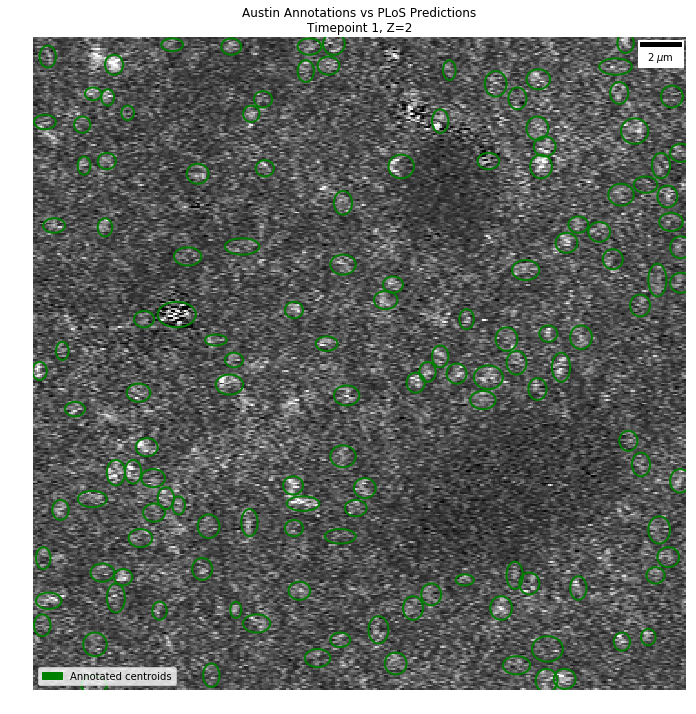

In [13]:
plt.figure(figsize=(12,12))
plt.gca().imshow(base_images[0][1])

for idx, row in raw_annotations[0][raw_annotations[0]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch])
plt.axis('off')
plt.title('Austin Annotations vs PLoS Predictions\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);

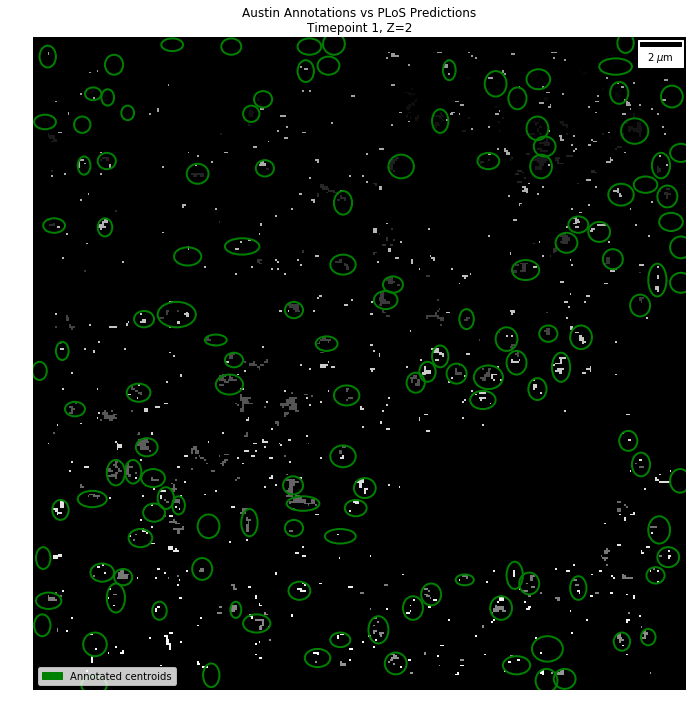

In [14]:
plt.figure(figsize=(12,12))
plt.gca().imshow(plos_images[0][1])

for idx, row in raw_annotations[0][raw_annotations[0]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch])
plt.axis('off')
plt.title('Austin Annotations vs PLoS Predictions\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);

# Aggregating Annotations
We first aggregate all the annotations and attempt to do feature tracking with them. This gives us a good baseline to compare to the predicted synapse tracking.

In [15]:
annotation_df = pd.DataFrame()
for timepoint in range(len(raw_annotations)):
    for _, row in raw_annotations[timepoint].iterrows():
        annotation_df = annotation_df.append([{'y': row['Y'] + row['Height']/2,
                                               'x': row['X'] + row['Width']/2,
                                               'z': row['Z'],
                                               'frame': timepoint+1
                                              }], ignore_index=True)

Now, we can apply the tracking algorithm!

In [16]:
search_range = 9
t = tp.link_df(annotation_df[annotation_df['z']==2], search_range, memory=1)

Frame 4: 105 trajectories present.


In [17]:
t1 = tp.filter_stubs(t, 2)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 279
After: 115


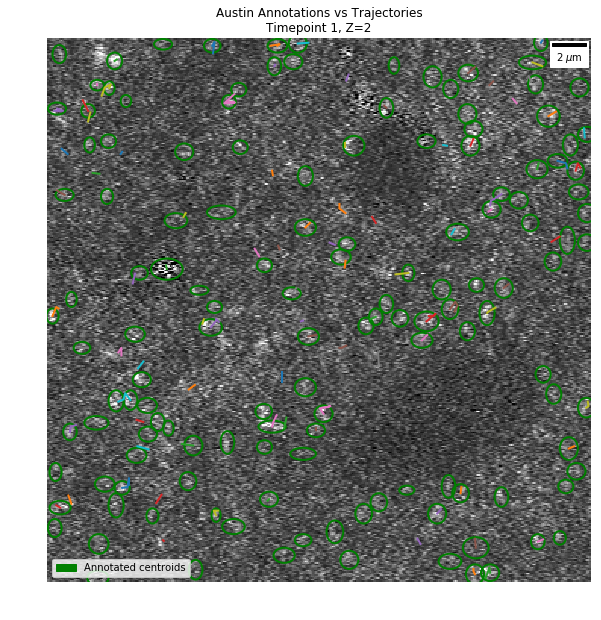

In [18]:
plt.figure(figsize=(10, 10))
tp.plot_traj(t1, superimpose=base_images[0][1], ax=plt.gca(), plot_style={'lw':2})

for idx, row in raw_annotations[0][raw_annotations[0]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)
    
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)
plt.axis('off')
plt.title('Austin Annotations vs Trajectories\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);

plt.savefig('./figures/tp1_tracking_with_annotation.png', dpi=300, bbox_inches='tight')

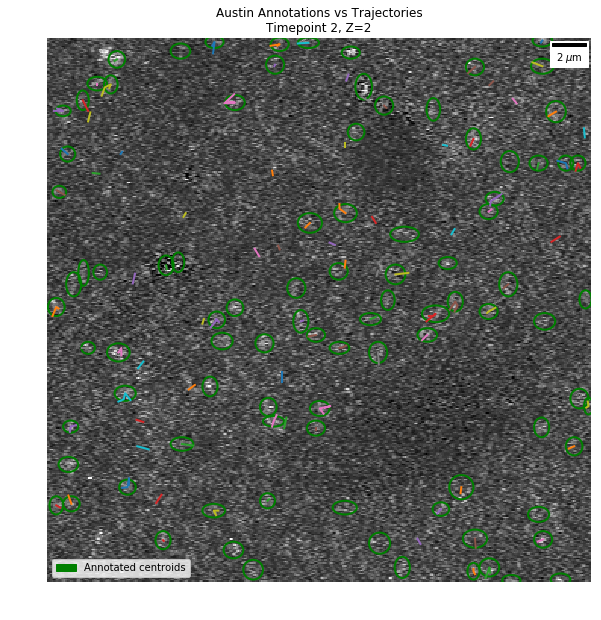

In [19]:
plt.figure(figsize=(10, 10))
plt.axis('off');
tp.plot_traj(t1, superimpose=base_images[1][1], ax=plt.gca(), plot_style={'lw':2})

for idx, row in raw_annotations[1][raw_annotations[1]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)
    
annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)
plt.axis('off')
plt.title('Austin Annotations vs Trajectories\nTimepoint 2, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);


plt.savefig('./figures/tp2_tracking_with_annotation.png', dpi=300, bbox_inches='tight')

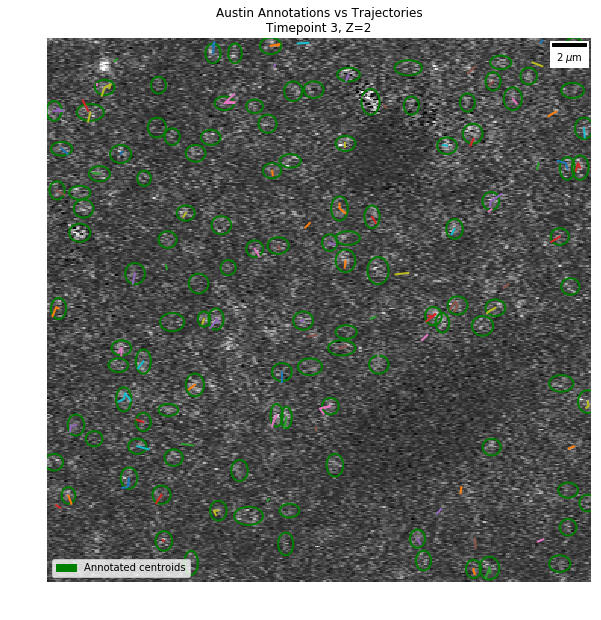

In [20]:
plt.figure(figsize=(10, 10))
plt.axis('off');
tp.plot_traj(t1, superimpose=base_images[2][1], ax=plt.gca(), plot_style={'lw':2})

for idx, row in raw_annotations[2][raw_annotations[2]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)
plt.axis('off')
plt.title('Austin Annotations vs Trajectories\nTimepoint 3, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
    
    
plt.savefig('./figures/tp3_tracking_with_annotation.png', dpi=300, bbox_inches='tight')

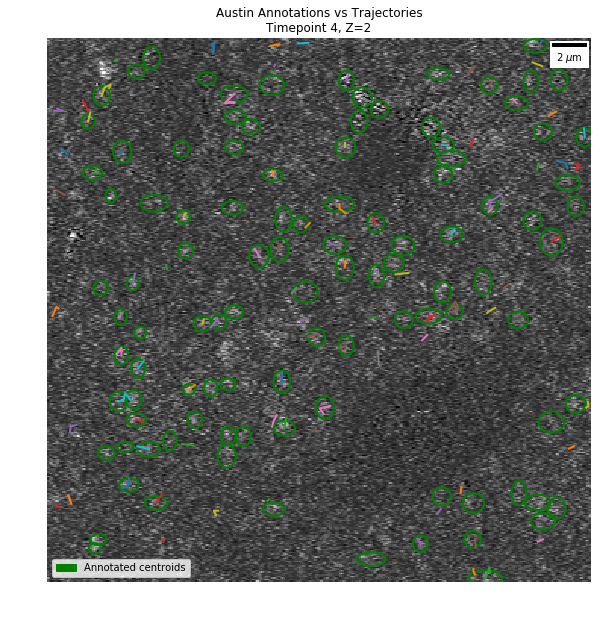

In [21]:
plt.figure(figsize=(10, 10))
plt.axis('off');
tp.plot_traj(t1, superimpose=base_images[3][1], ax=plt.gca(), plot_style={'lw':2})

for idx, row in raw_annotations[3][raw_annotations[3]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)
plt.axis('off')
plt.title('Austin Annotations vs Trajectories\nTimepoint 4, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);


plt.savefig('./figures/tp4_tracking_with_annotation.png', dpi=300, bbox_inches='tight')

In [22]:
filenames = ['tp1_tracking_with_annotation.png',
             'tp2_tracking_with_annotation.png',
             'tp3_tracking_with_annotation.png',
             'tp4_tracking_with_annotation.png']
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./figures/tracking_with_annotations_z2.gif', images, duration=0.5)

![](./figures/tracking_with_annotations_z2.gif?raw=true)

# Aggregating Predicted Synapses

Our features are the synapses detected by the PLoS algorithm. We use scikit-image with the labeling function to detect the synapses. The function returns several values such as the position, the mean intensity, the area, the eccentricity, etc. that can be used to remove false-postive labels. In our example, we must choose smart criterions. This is an area we can automate better; the current choices are all empirically chosen.

## Distribution of mass/area of predicted synapses

Now, let's look at the frequencies of mass and intensity in the images. For simplicity, we'll only look at the first timepoint. For this, we use region detection algorithms on the PLoS predictions. This effectively lets us extract regions of interest (synapses) from the prediction image.

First, we need to label the image of results. Then, we can extract regions from the labeled image.

In [23]:
label_im = measure.label(np.array(plos_images[0][1]))
mass = []
area_px = []
area_um = []

for region in measure.regionprops(label_im, plos_images[0][1]):
    area_px.append(region.area)
    area_um.append(region.area * 0.09 * 0.09)
    mass.append(region.weighted_moments[0][0])


Alright, let's see first where the detected synapses are.

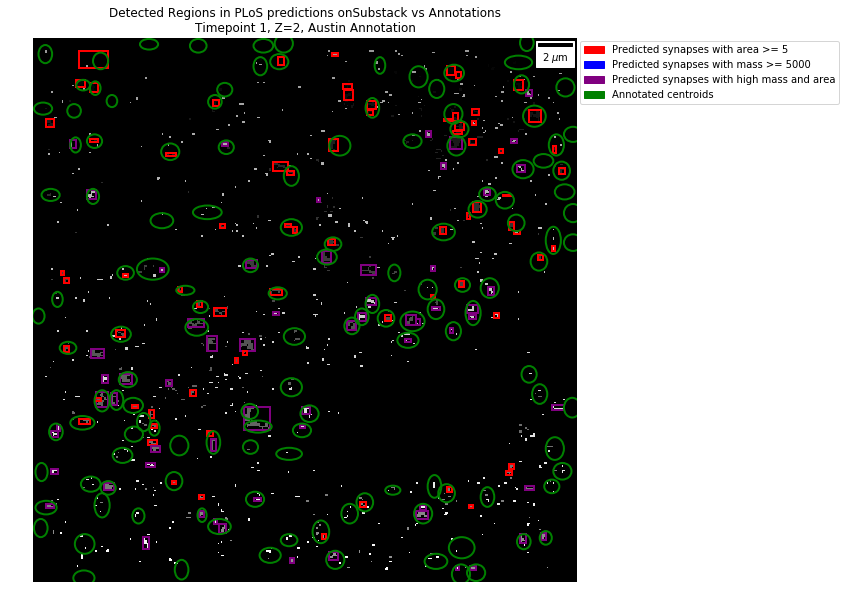

In [24]:
plotting.overlay_annotations_cc(plos_images[0][1], 
                                raw_annotations[0][raw_annotations[0]['Z']==2], 
                                title='Detected Regions in PLoS predictions on' 
                                'Substack vs Annotations\nTimepoint 1, Z=2, Austin Annotation'
                               )

## Tracking!

First, we'll demonstrate tracking using PLoS synapses and the PLoS results image.

In [25]:
plos_features = pd.DataFrame()

for timepoint in range(4):
    for z in range(1,3):
        label_image = measure.label(plos_images[timepoint][z])
        for region in measure.regionprops(label_image, intensity_image=plos_images[timepoint][z]):
            if region.area < 2 or region.area > 20:
                continue
            if region.weighted_moments[0][0] < 1000:
                continue
                
            # Store features which survived to the criterions
            plos_features = plos_features.append([{'y': region.centroid[0],
                                                   'x': region.centroid[1],
                                                   'z': z+1,
                                                   'mass': region.weighted_moments[0][0],
                                                   'area': region.area,
                                                   'frame': timepoint+1
                                                  }],ignore_index=True)

In [26]:
search_range = 10
t = tp.link_df(plos_features[plos_features['z']==2], search_range, memory=2)

Frame 4: 354 trajectories present.


Let's only look at the particles that are in all four time points.

In [27]:
t1 = tp.filter_stubs(t, 4)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 650
After: 73


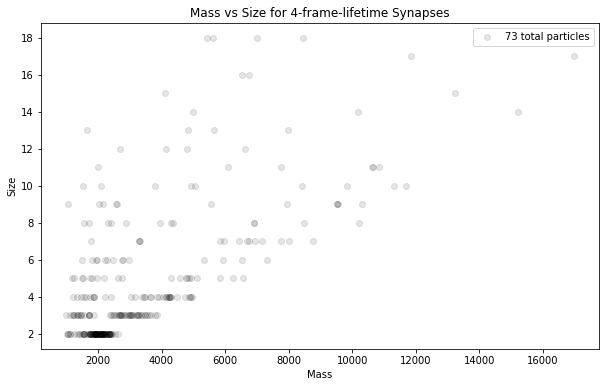

In [28]:
plt.figure()
plt.title('Mass vs Size for 4-frame-lifetime Synapses')
plt.xlabel('Mass')
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
count = len(df.particle.unique())
plt.scatter(df['mass'], df['area'], c='k', alpha=0.1, label="{} total particles".format(count))
plt.legend()

Text(0.5,1,'Mass of Particles vs Time\nParticles with lifetime 3+ (214 Trajectories)')

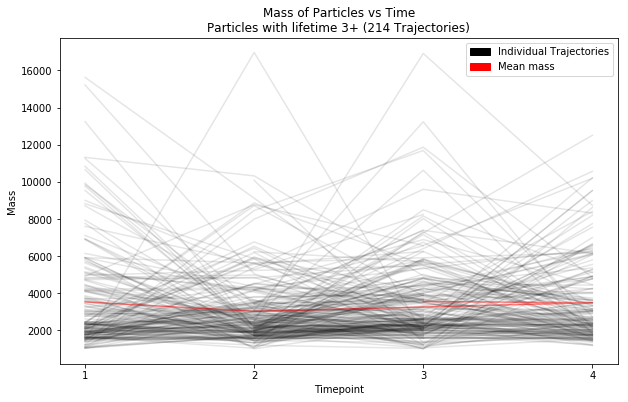

In [29]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Mass')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) >= 3)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['mass'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))

means = [df[df['frame']==i]['mass'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean mass')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Mass of Particles vs Time\nParticles with lifetime 3+ ({} Trajectories)".format(len(df.particle.unique())));

Text(0.5,1,'Mass of Particles vs Time\nParticles with lifetime 4 (73 Trajectories)')

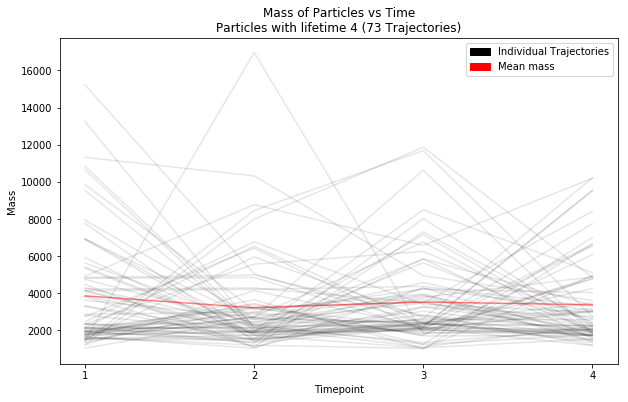

In [30]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Mass')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['mass'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))

means = [df[df['frame']==i]['mass'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean mass')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Mass of Particles vs Time\nParticles with lifetime 4 ({} Trajectories)".format(len(df.particle.unique())));

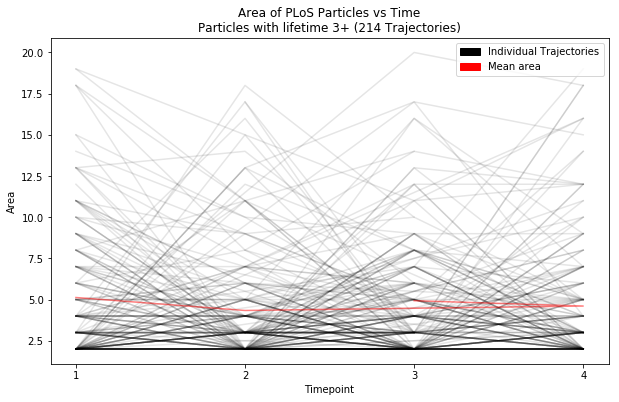

In [31]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Area')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) >= 3)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['area'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))
    
means = [df[df['frame']==i]['area'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean area')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Area of PLoS Particles vs Time\nParticles with lifetime 3+ ({} Trajectories)".format(len(df.particle.unique())));

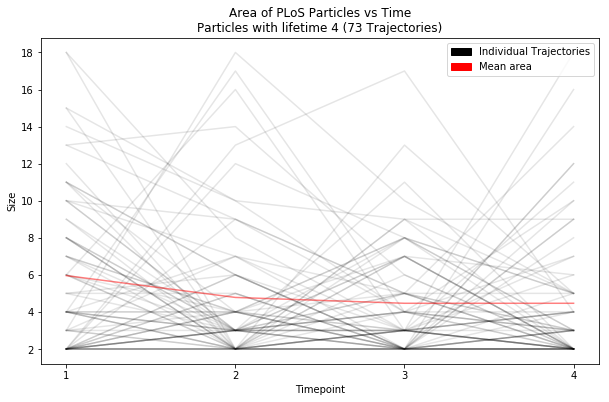

In [32]:
plt.figure(figsize=(10, 6))
plt.xlabel('Timepoint')
plt.xticks(np.arange(4))
plt.ylabel('Size')
df = pd.concat(g for _, g in t.groupby("particle") if len(g) == 4)
for i in df.particle.unique():
    df1 = t.loc[t['particle'] == i]
    plt.plot(df1['frame'], df1['area'], 'k-', alpha=0.1)
    plt.xticks(np.arange(1, 5, step=1))
    
    
means = [df[df['frame']==i]['area'].mean() for i in range(1,5)]
plt.plot(df['frame'].unique(), means, 'r-', alpha=0.5)

trajectories = mpl.patches.Patch(color='k', label='Individual Trajectories')
mean = mpl.patches.Patch(color='r', label='Mean area')
plt.legend(handles=[trajectories, mean], loc=1)
plt.title("Area of PLoS Particles vs Time\nParticles with lifetime 4 ({} Trajectories)".format(len(df.particle.unique())));

# Looking at Trajectories vs PLoS Results

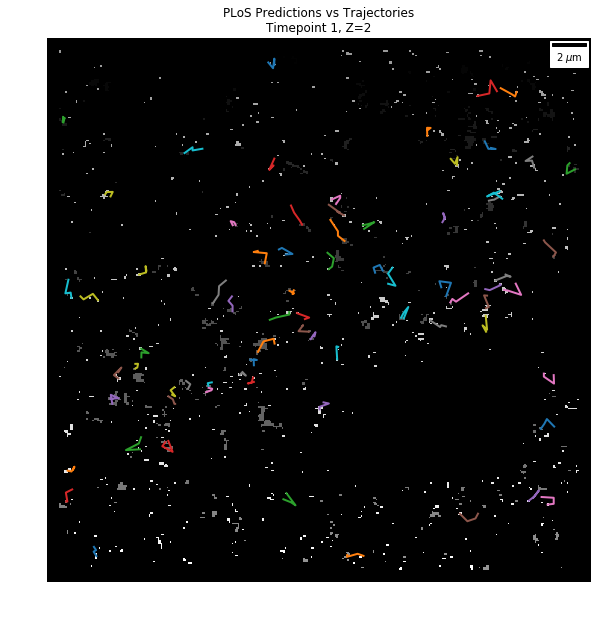

In [33]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=plos_images[0][1], plot_style={'lw':2})
plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp1_tracking_with_plos.png', dpi=300, bbox_inches='tight');

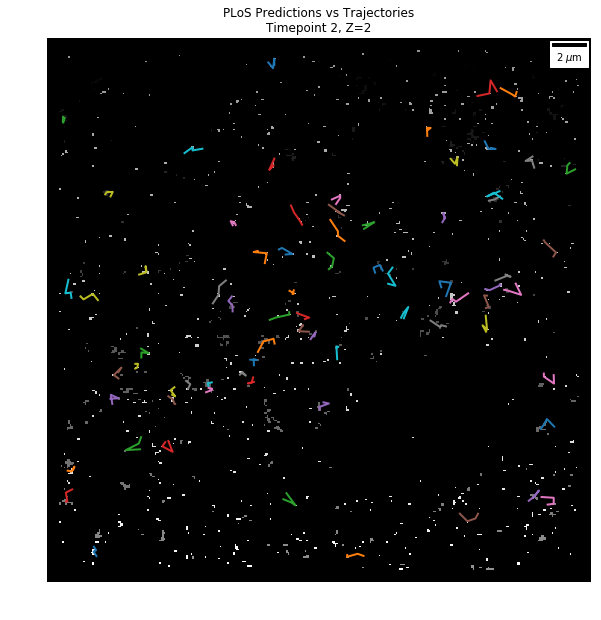

In [34]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=plos_images[1][1], plot_style={'lw':2})

plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 2, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp2_tracking_with_plos.png', dpi=300, bbox_inches='tight');

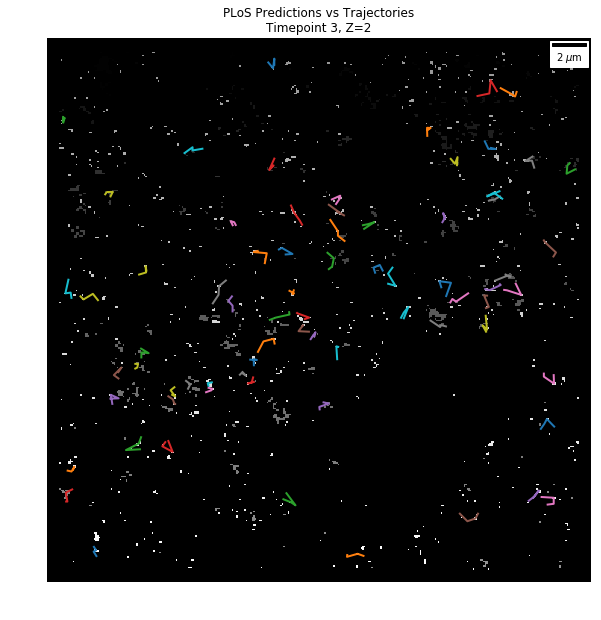

In [35]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=plos_images[2][1], plot_style={'lw':2})
plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 3, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp3_tracking_with_plos.png', dpi=300, bbox_inches='tight');

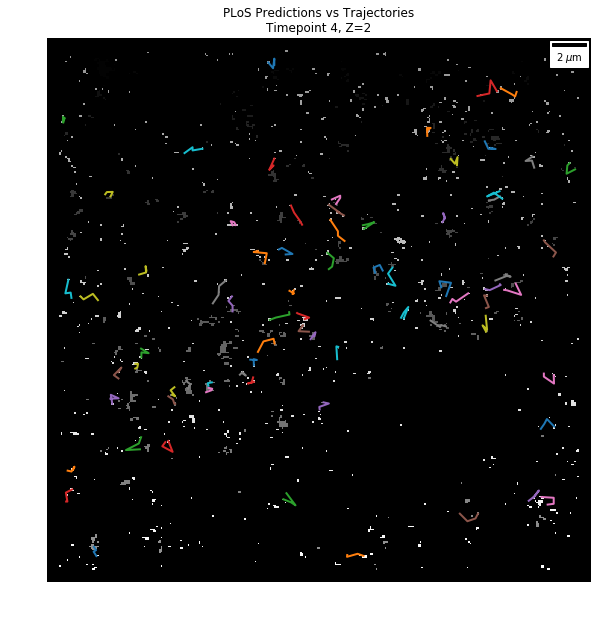

In [36]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=plos_images[3][1], plot_style={'lw':2})
plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 4, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp4_tracking_with_plos.png', dpi=300, bbox_inches='tight');

In [37]:
filenames = ['./tp1_tracking_with_plos.png',
             './tp2_tracking_with_plos.png',
             './tp3_tracking_with_plos.png',
             './tp4_tracking_with_plos.png']
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./tracking_with_plos_z2.gif', images, duration=0.5)

![](./tracking_with_plos_z2.gif?raw=true)

# Looking at Trajectories generated from PLoS vs Annotations

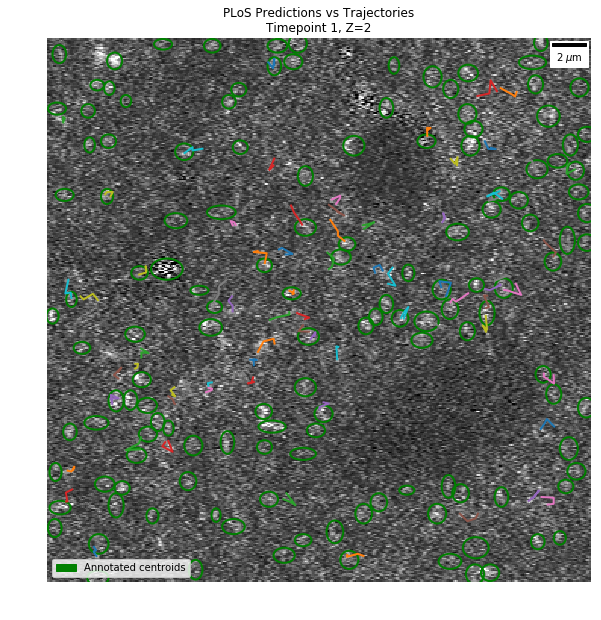

In [38]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=base_images[0][1], plot_style={'lw':2})

for idx, row in raw_annotations[0][raw_annotations[0]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)

plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 1, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp1_tracking_with_plos_vs_ann.png', dpi=300, bbox_inches='tight');

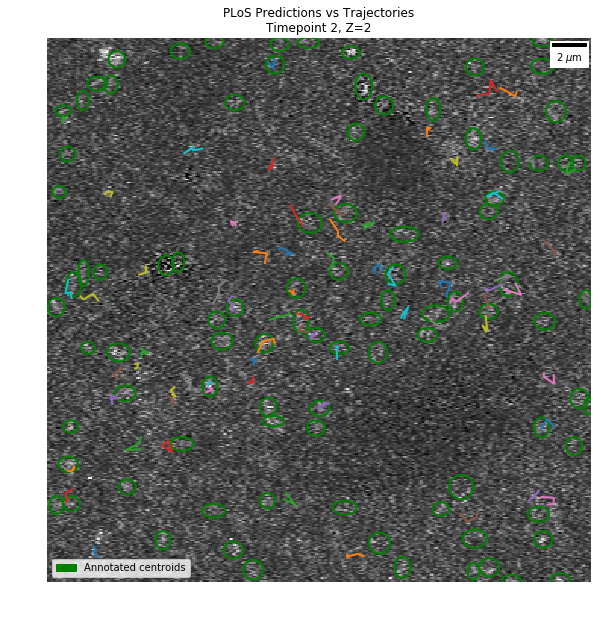

In [39]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=base_images[1][1], plot_style={'lw':2})

for idx, row in raw_annotations[1][raw_annotations[1]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)

plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 2, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp2_tracking_with_plos_vs_ann.png', dpi=300, bbox_inches='tight');

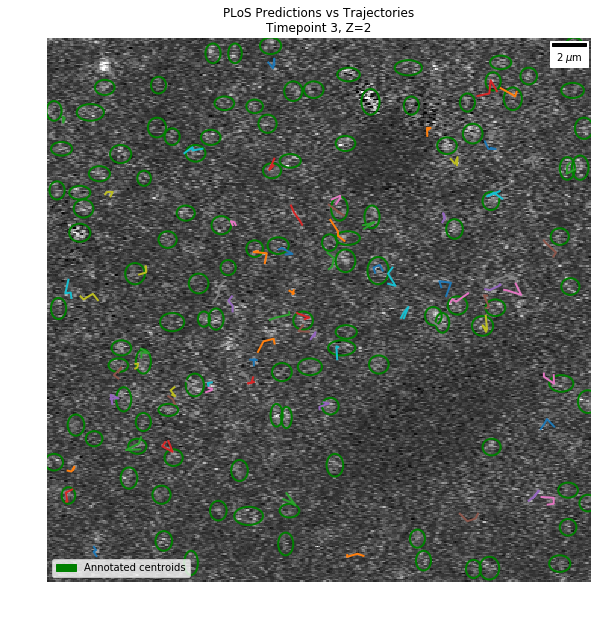

In [40]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=base_images[2][1], plot_style={'lw':2})

for idx, row in raw_annotations[2][raw_annotations[2]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)

plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 3, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp3_tracking_with_plos_vs_ann.png', dpi=300, bbox_inches='tight');

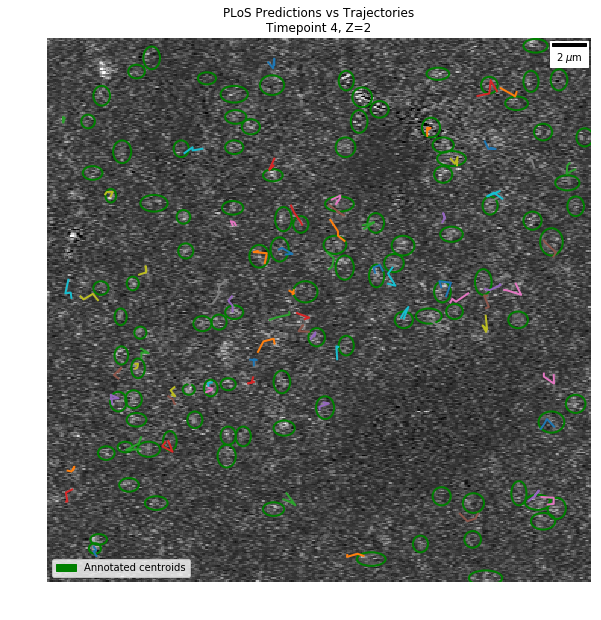

In [41]:
plt.figure(figsize=(10,10))
tp.plot_traj(t1, ax=plt.gca(), superimpose=base_images[3][1], plot_style={'lw':2})

for idx, row in raw_annotations[3][raw_annotations[3]['Z']==2].iterrows():
    x = row['X'] + row['Width']/2
    y = row['Y'] + row['Height']/2
    elps = mpl.patches.Ellipse((x,y), width=row['Width'], height=row['Height'], edgecolor='g', lw=2, facecolor='none')
    plt.gca().add_patch(elps)

annotation_patch = mpl.patches.Patch(color='green', label='Annotated centroids')
plt.legend(handles=[annotation_patch], loc=3)

plt.axis('off')
plt.title('PLoS Predictions vs Trajectories\nTimepoint 4, Z=2');
scalebar = ScaleBar(0.09, 'um', length_fraction=0.1, height_fraction=0.005, color='k', border_pad=0.3) # 1 pixel = 0.09 um
plt.gca().add_artist(scalebar);
plt.savefig('./figures/tp4_tracking_with_plos_vs_ann.png', dpi=300, bbox_inches='tight');

In [42]:
filenames = ['./tp1_tracking_with_plos_vs_ann.png',
             './tp2_tracking_with_plos_vs_ann.png',
             './tp3_tracking_with_plos_vs_ann.png',
             './tp4_tracking_with_plos_vs_ann.png']
images = []

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./figures/tracking_with_plos_vs_ann_z2.gif', images, duration=0.5)

![](./tracking_with_plos_vs_ann_z2.gif?raw=true)

# Measuring F-1

To quantify how good the PLoS predictions are, we measure the F-1 score relative to both sets of expert annotations (Austin and Richard).

First up, we'll calculate F-1 relative to Austin's predictions. A predicted synapse is considered "correct" if the center of predicted synapse lies within the bounding box of the annotation ellipse. 


Area Thresholding
0.0
4.444444444444445
8.88888888888889
13.333333333333334
17.77777777777778
22.22222222222222
26.666666666666668
31.111111111111114
35.55555555555556
40.0
Mass Thresholding
0.0
1296.0
2592.0
3888.0
5184.0
6480.0
7776.0
9072.0
10368.0
11664.0


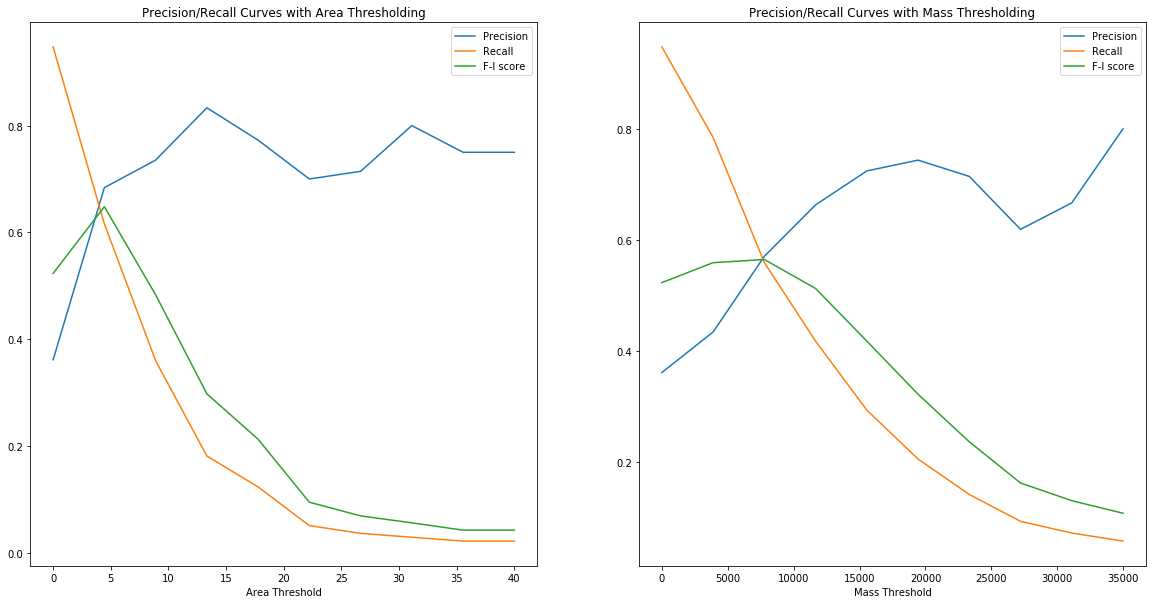

In [43]:
results = utils.f1_plot(plos_images[0][1], 
                        raw_annotations[0][raw_annotations[0]['Z']==2], 
                        './figures/prec_recall_area_mass_thresholding.png',
                        spacing=10)

In [63]:
%autoreload

stats = plotting.stats_multithreshold(plos_images[0][1], raw_annotations[0][raw_annotations[0]['Z']==2], spacing=10)

Area = 0.0
Mass = 0.0
Area = 0.0
Mass = 1296.0
Area = 0.0
Mass = 2592.0
Area = 0.0
Mass = 3888.0
Area = 0.0
Mass = 5184.0
Area = 0.0
Mass = 6480.0
Area = 0.0
Mass = 7776.0
Area = 0.0
Mass = 9072.0
Area = 0.0
Mass = 10368.0
Area = 0.0
Mass = 11664.0
Area = 4.444444444444445
Mass = 0.0
Area = 4.444444444444445
Mass = 1296.0
Area = 4.444444444444445
Mass = 2592.0
Area = 4.444444444444445
Mass = 3888.0
Area = 4.444444444444445
Mass = 5184.0
Area = 4.444444444444445
Mass = 6480.0
Area = 4.444444444444445
Mass = 7776.0
Area = 4.444444444444445
Mass = 9072.0
Area = 4.444444444444445
Mass = 10368.0
Area = 4.444444444444445
Mass = 11664.0
Area = 8.88888888888889
Mass = 0.0
Area = 8.88888888888889
Mass = 1296.0
Area = 8.88888888888889
Mass = 2592.0
Area = 8.88888888888889
Mass = 3888.0
Area = 8.88888888888889
Mass = 5184.0
Area = 8.88888888888889
Mass = 6480.0
Area = 8.88888888888889
Mass = 7776.0
Area = 8.88888888888889
Mass = 9072.0
Area = 8.88888888888889
Mass = 10368.0
Area = 8.8888888888888

In [65]:
stats = np.array(stats).reshape(10, 10, -1)

In [66]:
print(np.unravel_index(stats[:,:,2].argmax(), stats[:,:,2].shape))

(1, 0)


In [68]:
print(stats[1,0,:])

[0.68382353 0.61589404 0.64808362 0.61589404 0.6504065 ]


In [96]:
prec = pd.DataFrame(stats[:,:,0], columns=np.arange(0, 11660, 1166), index=0.1*np.linspace(0, 39, num=10))
recall = pd.DataFrame(stats[:,:,1], columns=np.arange(0, 11660, 1166), index=0.1*np.linspace(0, 39, num=10))
f1 = pd.DataFrame(stats[:,:,2], columns=np.arange(0, 11660, 1166), index=0.1*np.linspace(0, 39, num=10))

In [97]:
f1

0         1166      2332      3498      4664      5830   \
0.000000  0.523161  0.559055  0.564784  0.512605  0.417910  0.322222   
0.433333  0.648084  0.593156  0.551440  0.491071  0.417910  0.322222   
0.866667  0.483092  0.426396  0.406250  0.365591  0.333333  0.290698   
1.300000  0.297619  0.245399  0.245399  0.225000  0.202532  0.168831   
1.733333  0.212500  0.178344  0.178344  0.155844  0.143791  0.120000   
2.166667  0.094595  0.081633  0.081633  0.068493  0.068493  0.055172   
2.600000  0.068966  0.055556  0.055556  0.041958  0.041958  0.028169   
3.033333  0.055944  0.042254  0.042254  0.042254  0.042254  0.028369   
3.466667  0.042254  0.028369  0.028369  0.028369  0.028369  0.014286   
3.900000  0.042254  0.028369  0.028369  0.028369  0.028369  0.014286   

             6996      8162      9328      10494  
0.000000  0.236686  0.162500  0.130719  0.108108  
0.433333  0.236686  0.162500  0.130719  0.108108  
0.866667  0.218182  0.162500  0.130719  0.108108  
1.300000  0.132450  0.107383  0.095238  0.095890  
1.733333  0.094595  0.068493  0.055556  0.055944  
2.166667  0.041667  0.027972  0.028169  0.028369  
2.600000  0.028169  0.028169  0.028169  0.028369  
3.033333  0.028369  0.028369  0.028369  0.028369  
3.466667  0.014286  0.014286  0.014286  0.014286  
3.900000  0.014286  0.014286  0.014286  0.014286

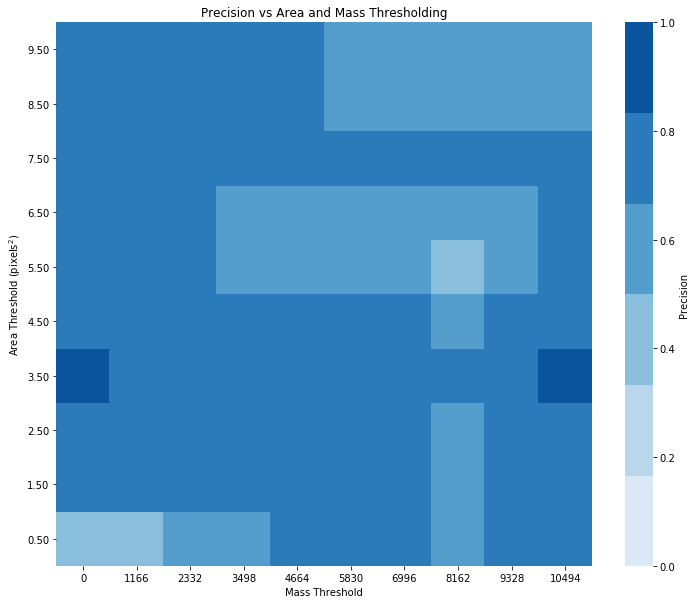

In [102]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(12, 10))
ax = sns.heatmap(prec, cmap=sns.color_palette("Blues"), 
                 xticklabels=1, yticklabels=1, 
                 cbar_kws={'label': 'Precision'}, 
                 vmin=0, vmax=1)

ax.set(title='Precision vs Area and Mass Thresholding', 
       xlabel='Mass Threshold', 
       ylabel=r'Area Threshold (pixels$^2$)')

ax.set(ylim=(0, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()
fig = ax.get_figure()
fig.savefig('./figures/precision_heatmap.png', dpi=300)

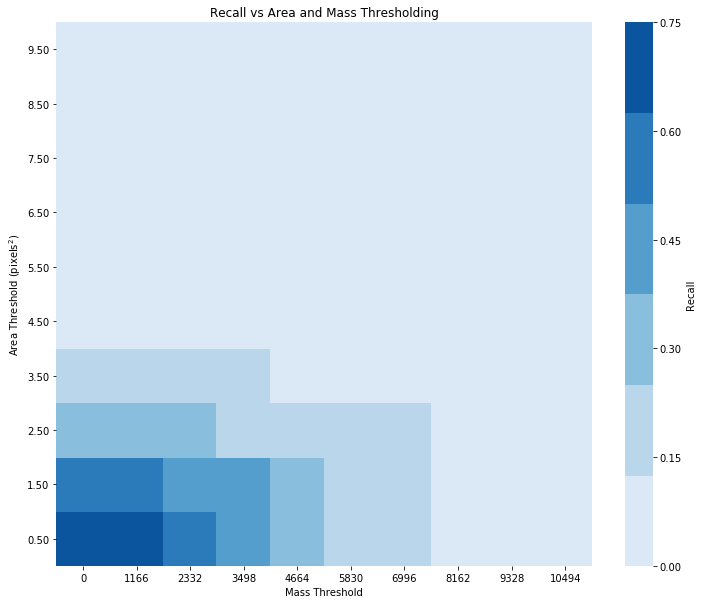

In [103]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(recall, cmap=sns.color_palette("Blues"), 
                 xticklabels=1, yticklabels=1, 
                 cbar_kws={'label': 'Recall'}, 
                 vmax=0, vmin=0.75)

ax.set(title='Recall vs Area and Mass Thresholding', 
       xlabel='Mass Threshold', 
       ylabel=r'Area Threshold (pixels$^2$)')

ax.set(ylim=(0, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()
fig = ax.get_figure()
fig.savefig('./figures/recall_heatmap.png', dpi=300)

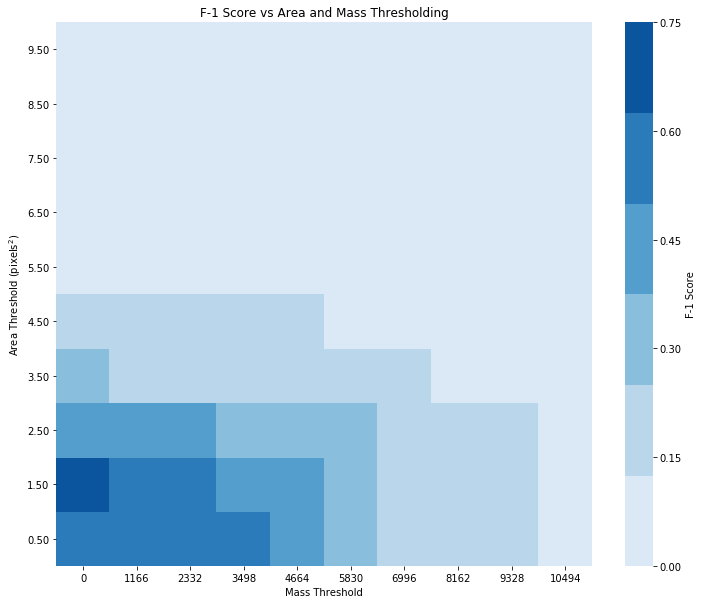

In [104]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(f1, cmap=sns.color_palette("Blues"), 
                 xticklabels=1, yticklabels=1, 
                 cbar_kws={'label': 'F-1 Score'}, vmin=0, vmax=.75)
ax.set(title='F-1 Score vs Area and Mass Thresholding', 
       xlabel='Mass Threshold', 
       ylabel=r'Area Threshold (pixels$^2$)')
ax.set(ylim=(0, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()
fig = ax.get_figure()
fig.savefig('./figures/f1_heatmap.PNG', dpi=300)